In [38]:
# %%
import os
import numpy as np
from functools import partial
import math
from tqdm import tqdm
import time as time

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits
import skimage as ski

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg


True
1
0
NVIDIA A100-PCIE-40GB


In [3]:
# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 4999, "record_iters": False}
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
base_savedir = '/disk/xray0/tl3/outputs/large-scale-UQ/sampling/CRR'
save_dir = base_savedir + '/vars/'
savefig_dir = base_savedir + '/figs/'

img_name = 'M31'

# Load img
img_path = '/disk/xray0/tl3/repos/large-scale-UQ/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Load img
img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img


# Load op from X Cai
op_mask = sio.loadmat(
    repo_dir + '/data/operators_masks/fourier_mask.mat'
)['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

# Define my torch types
myType = torch.float32
myComplexType = torch.complex64

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape)


phi = luq.operators.MaskedFourier_torch(
    shape=img.shape, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


# %%
# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
f = luq.operators.RealProx_torch()


# %%
# Load CRR model
torch.set_grad_enabled(False)
torch.set_num_threads(4)

sigma_training = 5
t_model = 5
dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(dir_name+exp_name, 'cuda:0', device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

# L_CRR = model.L.detach().cpu().squeeze().numpy()
# print(f"Lipschitz bound {L_CRR:.3f}")

# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")



--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


In [24]:
# %%

# CRR parameters
reg_params = [5e4]# , 1e6] # [250., 1e3, 5e3, 1e4, 5e4, 1e5]
mu = 20
# my_lmbda = [1e5] #, 5e4] # [2.5e3, 5e3, 1e4, 2e4, 5e4]


# LCI params
alpha_prob = 0.05

# Compute the MAP-based UQ plots
superpix_MAP_sizes = [32, 16, 8, 4]

# Compute the sampling UQ plots
superpix_sizes = [32,16,8,4,1]

# Sampling alg params
frac_delta = 0.98
frac_burnin = 0.1
n_samples = np.int64(5e4)
thinning = np.int64(1e1)
maxit = np.int64(n_samples * thinning * (1. + frac_burnin))
# SKROCK params
nStages = 10
eta = 0.05
dt_perc = 0.99


[GD] 0 out of 15000 iterations, tol = 0.074123
[GD] converged in 1033 iterations


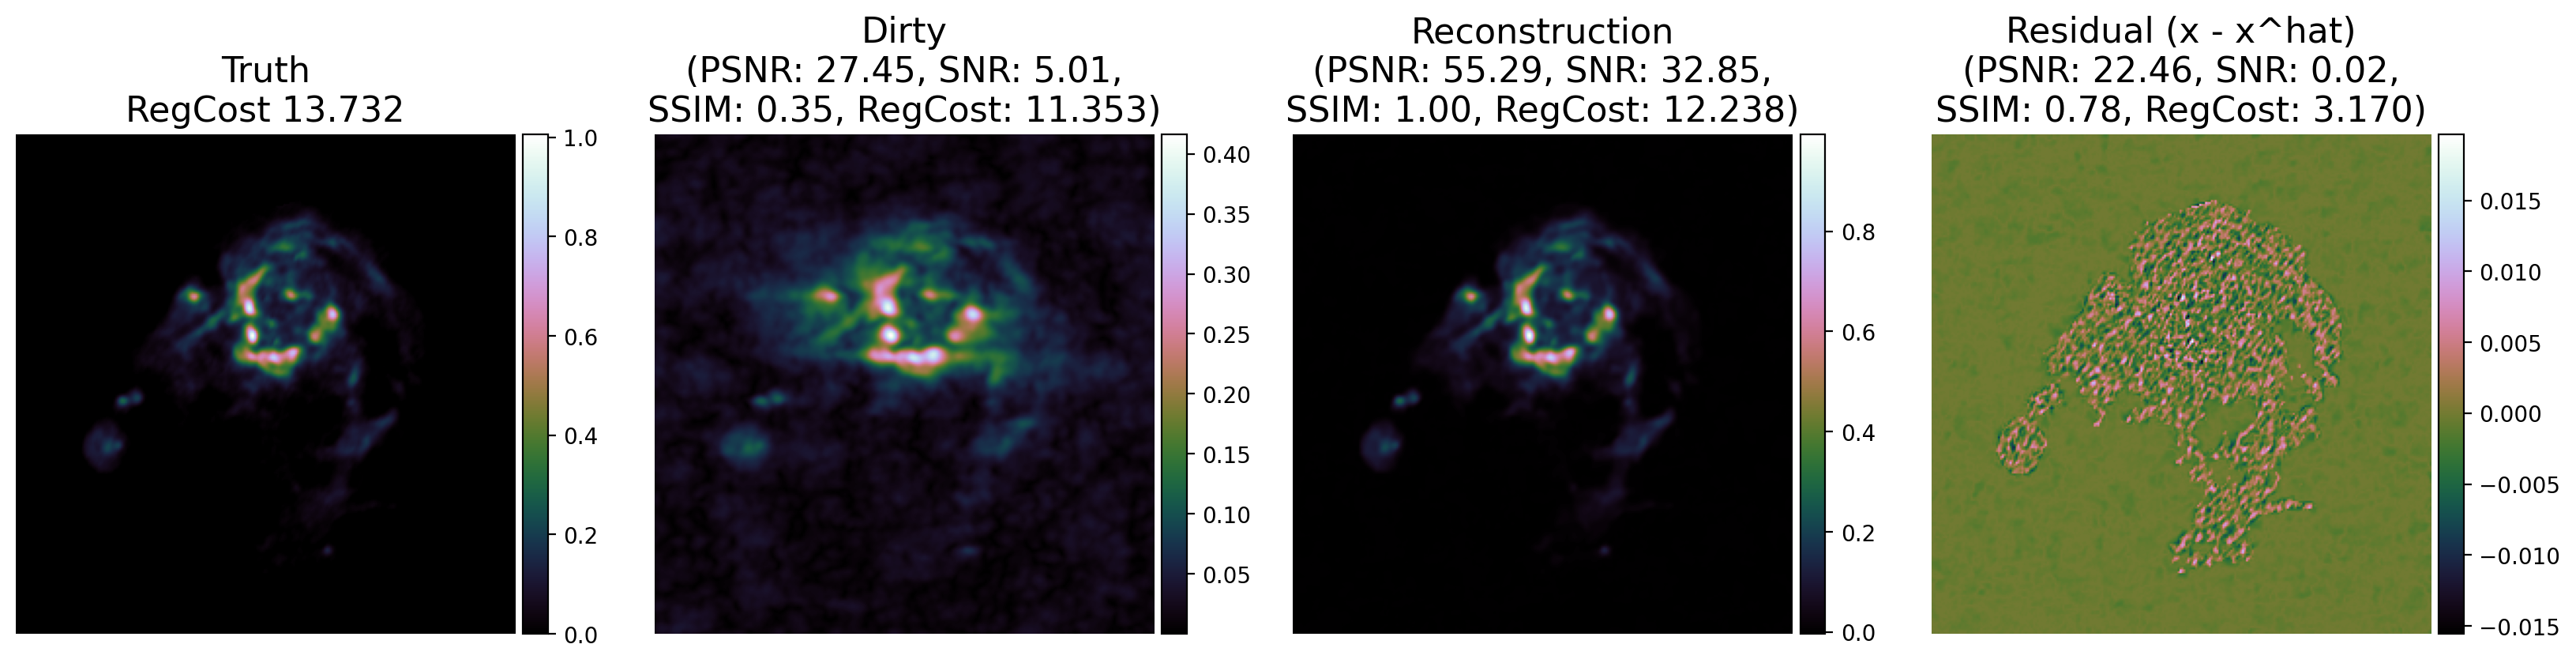

Calculating credible interval for superpxiel:  (256, 256)
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There

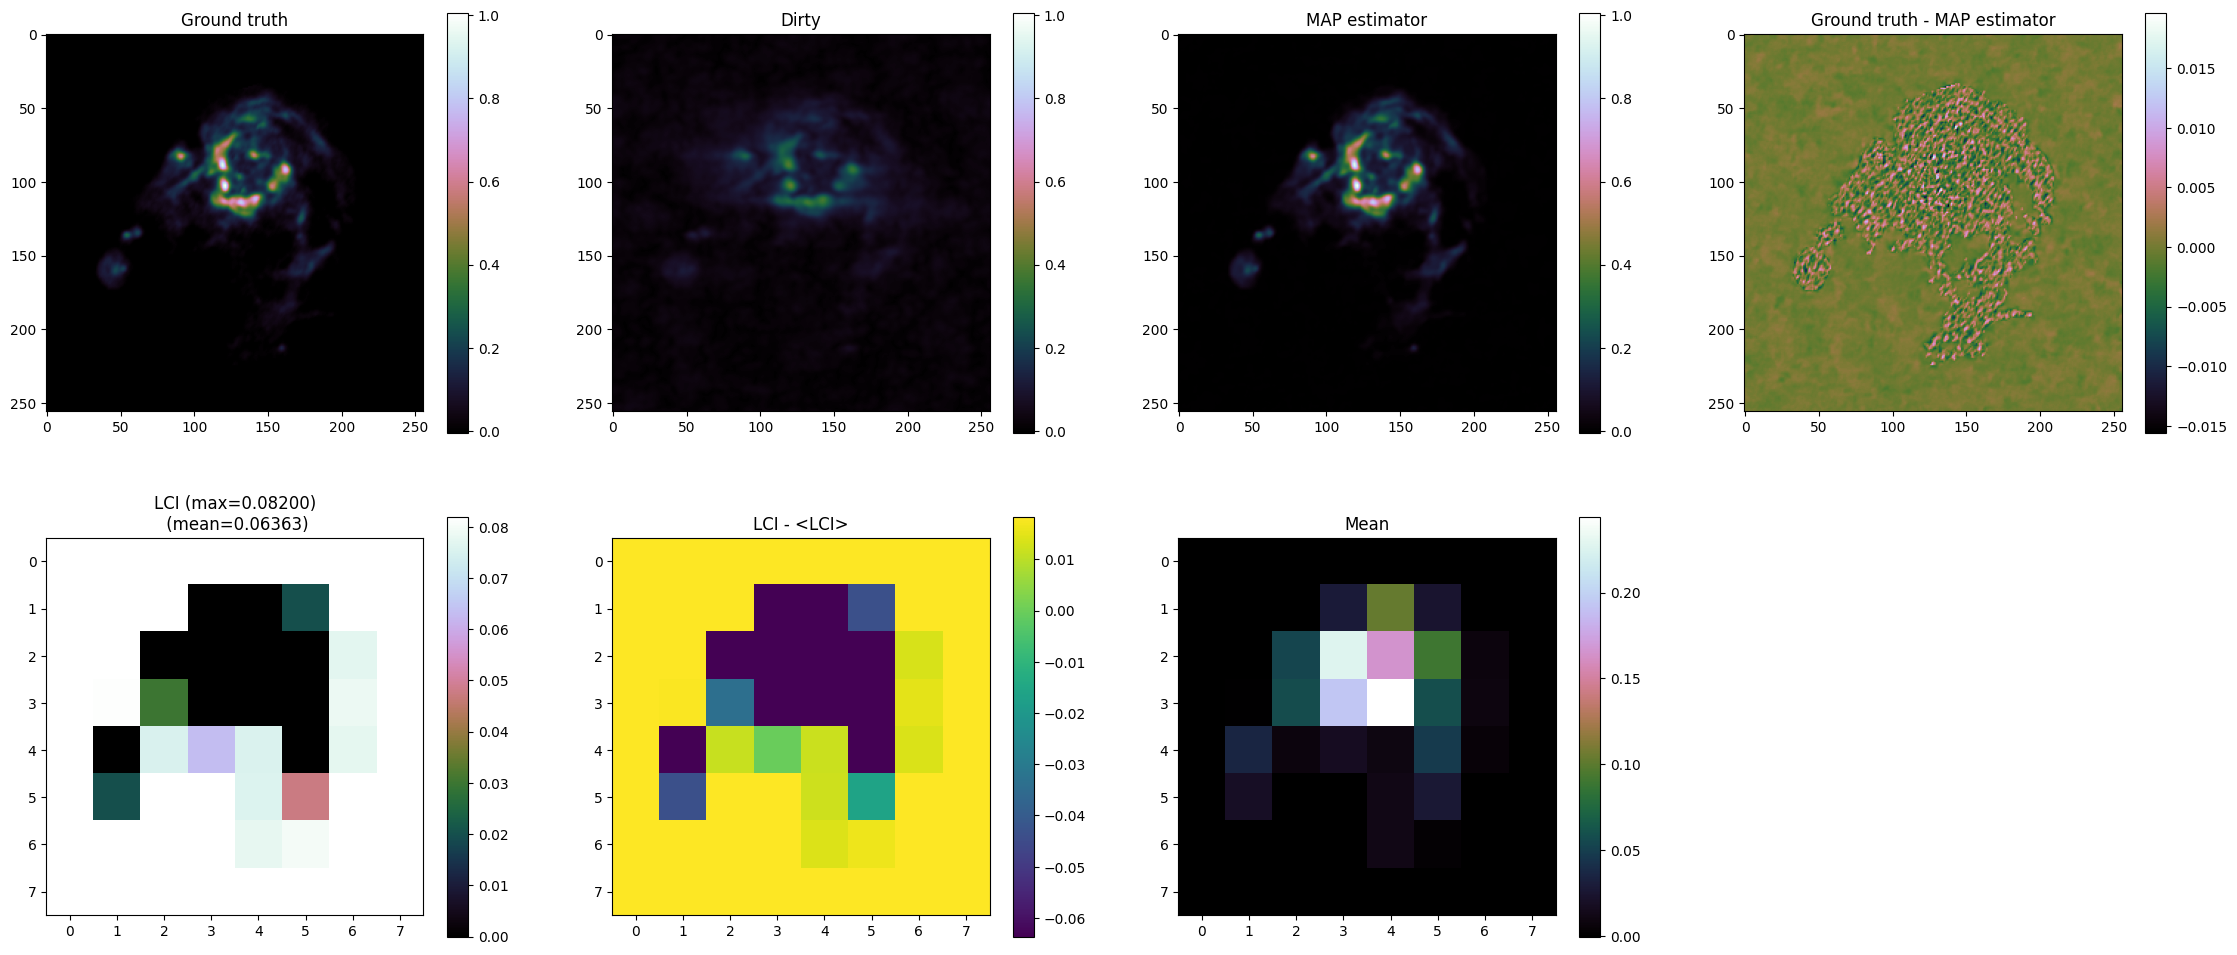

Calculating credible interval for superpxiel:  (256, 256)
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There

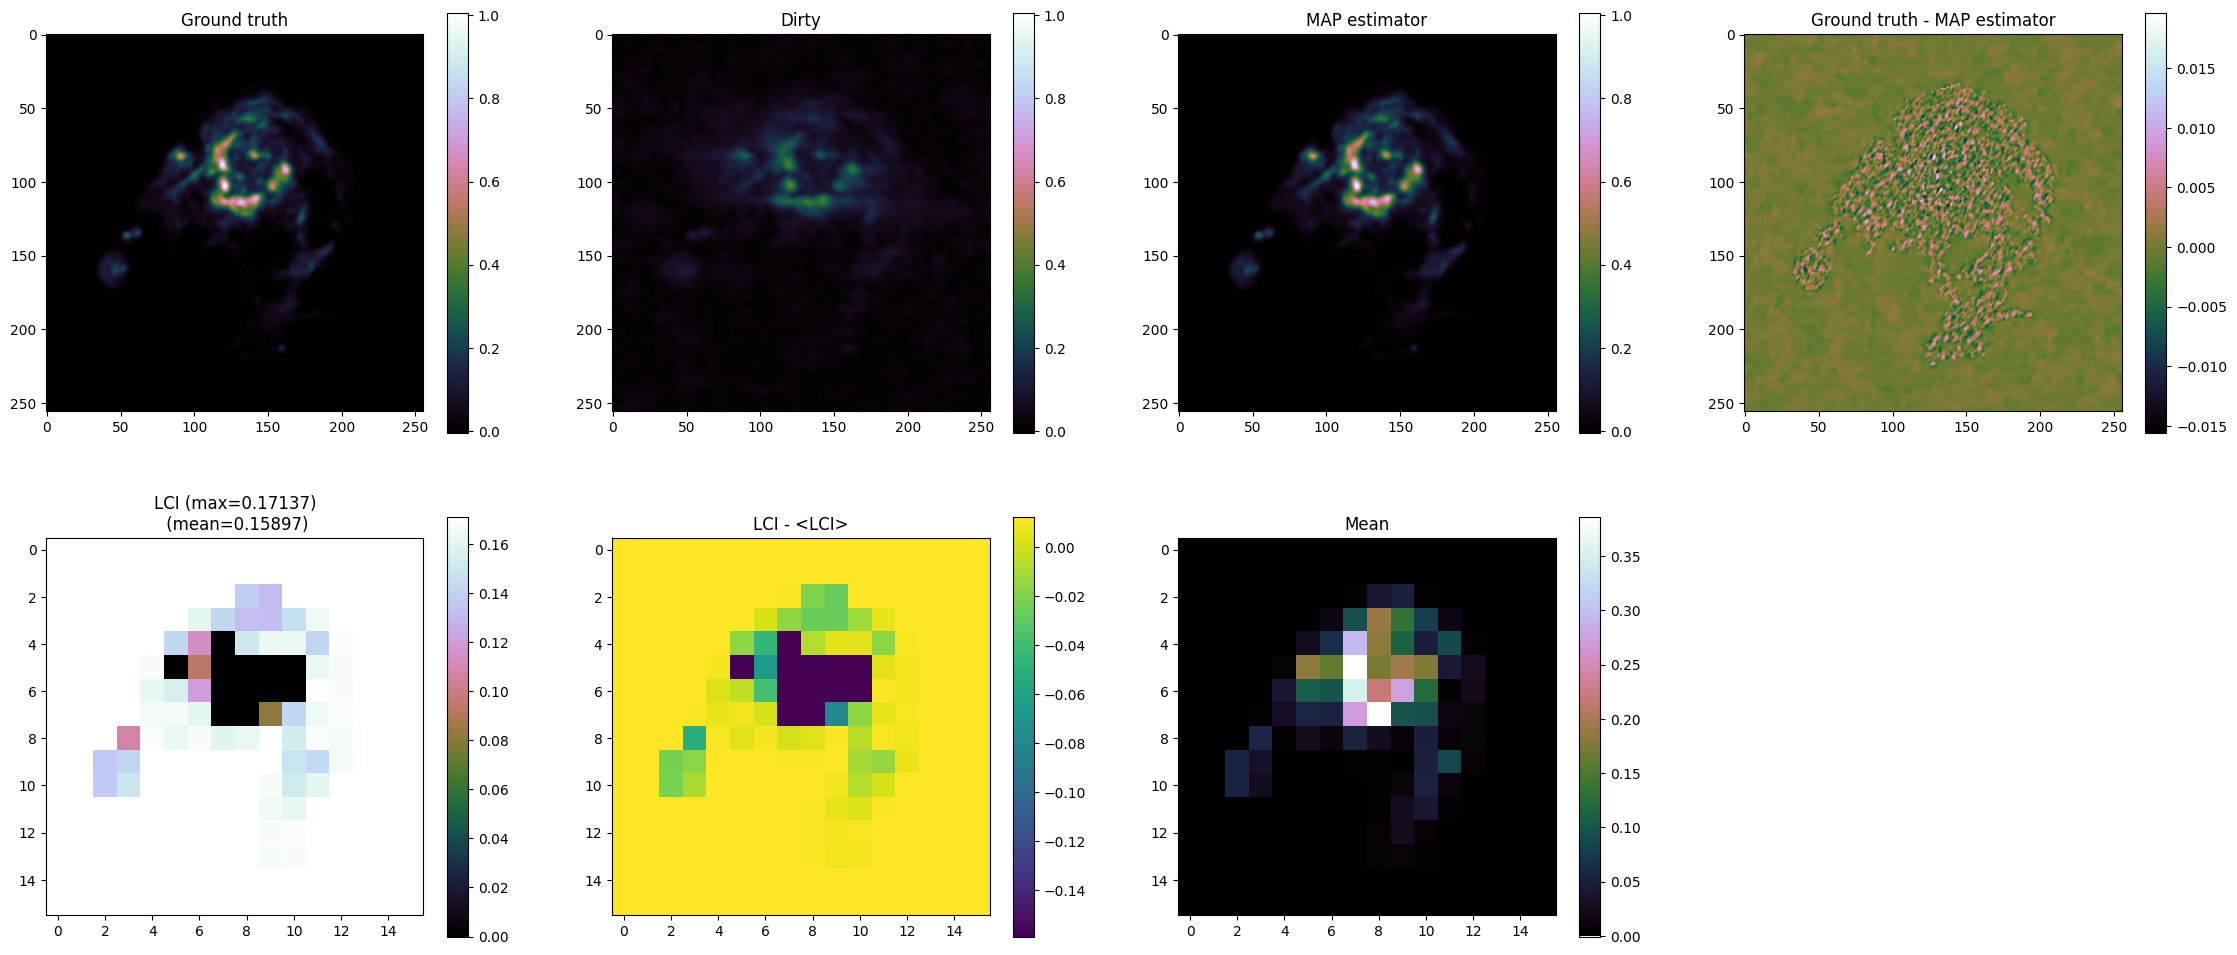

Calculating credible interval for superpxiel:  (256, 256)
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.
[Bisection Method] There is no root in this range.


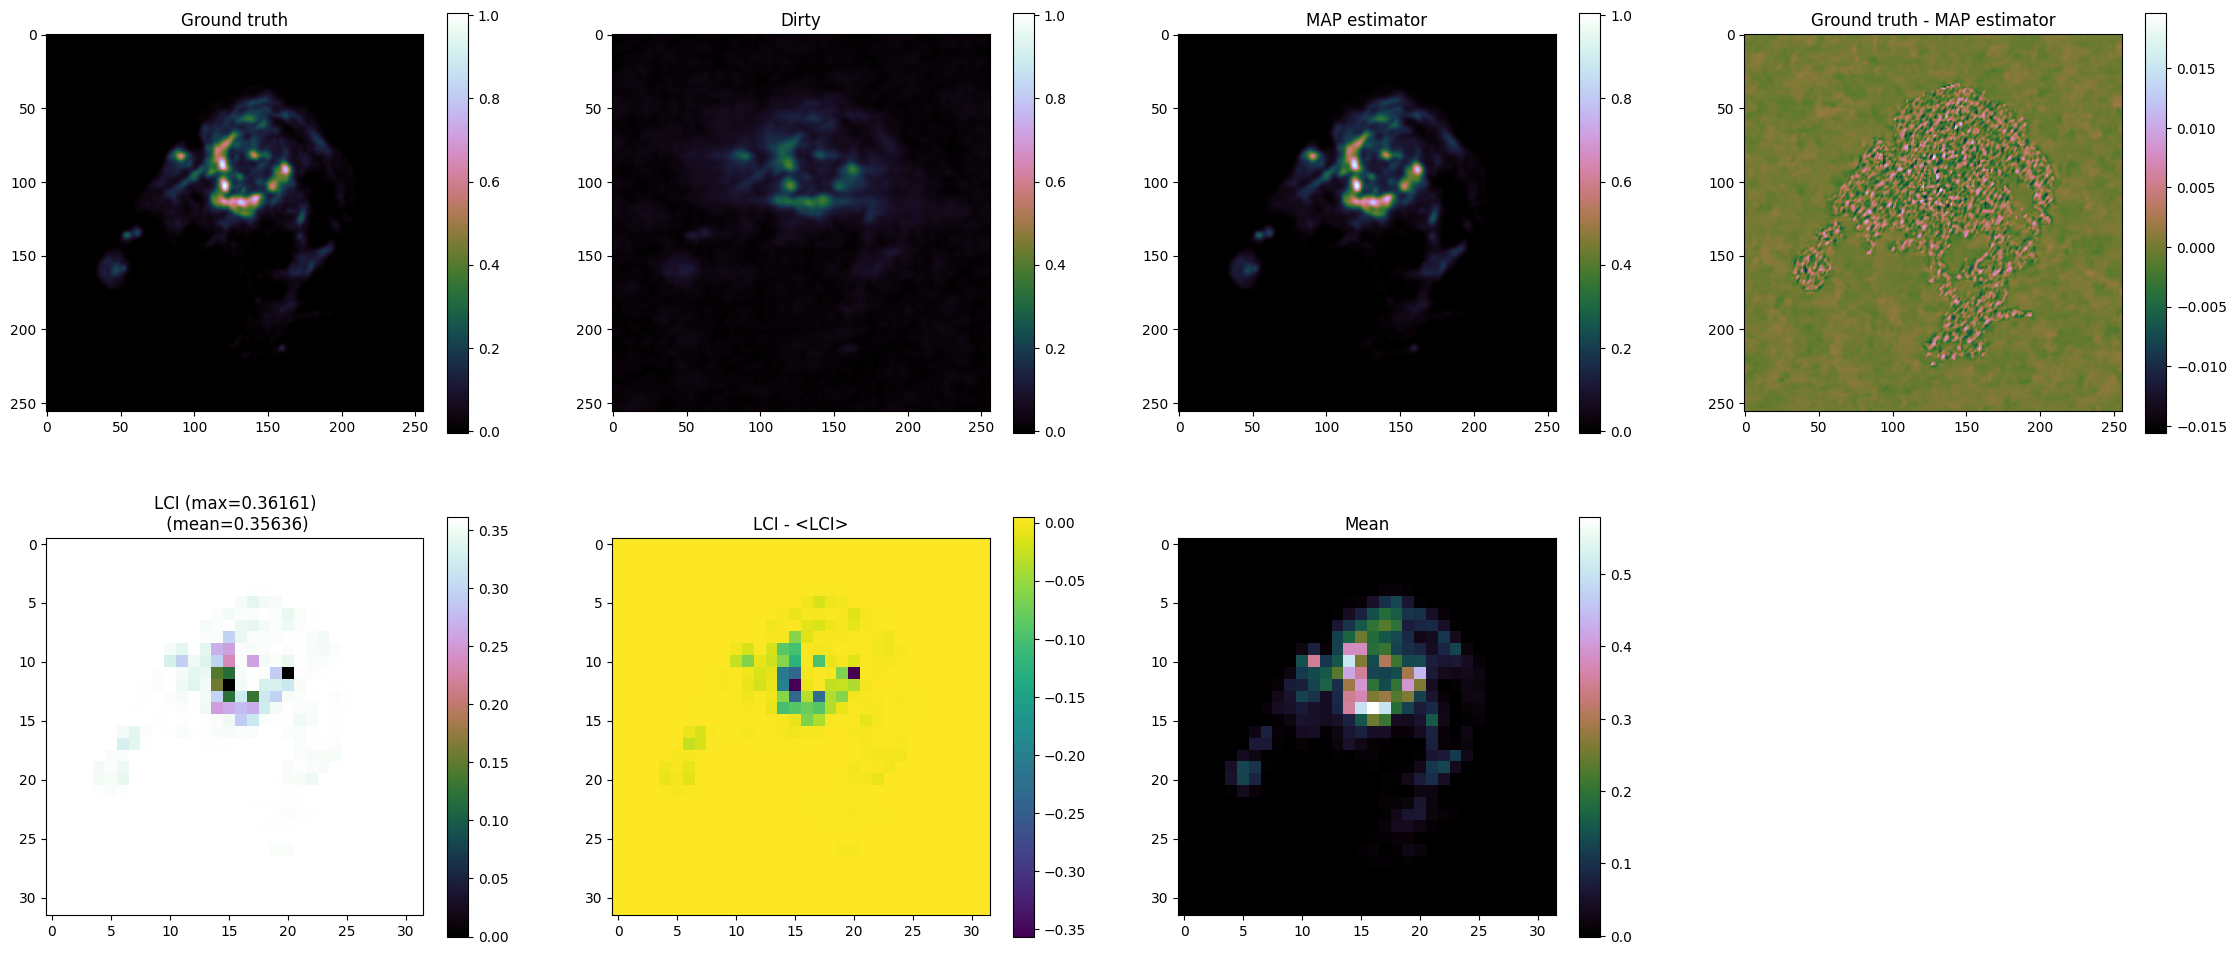

Calculating credible interval for superpxiel:  (256, 256)


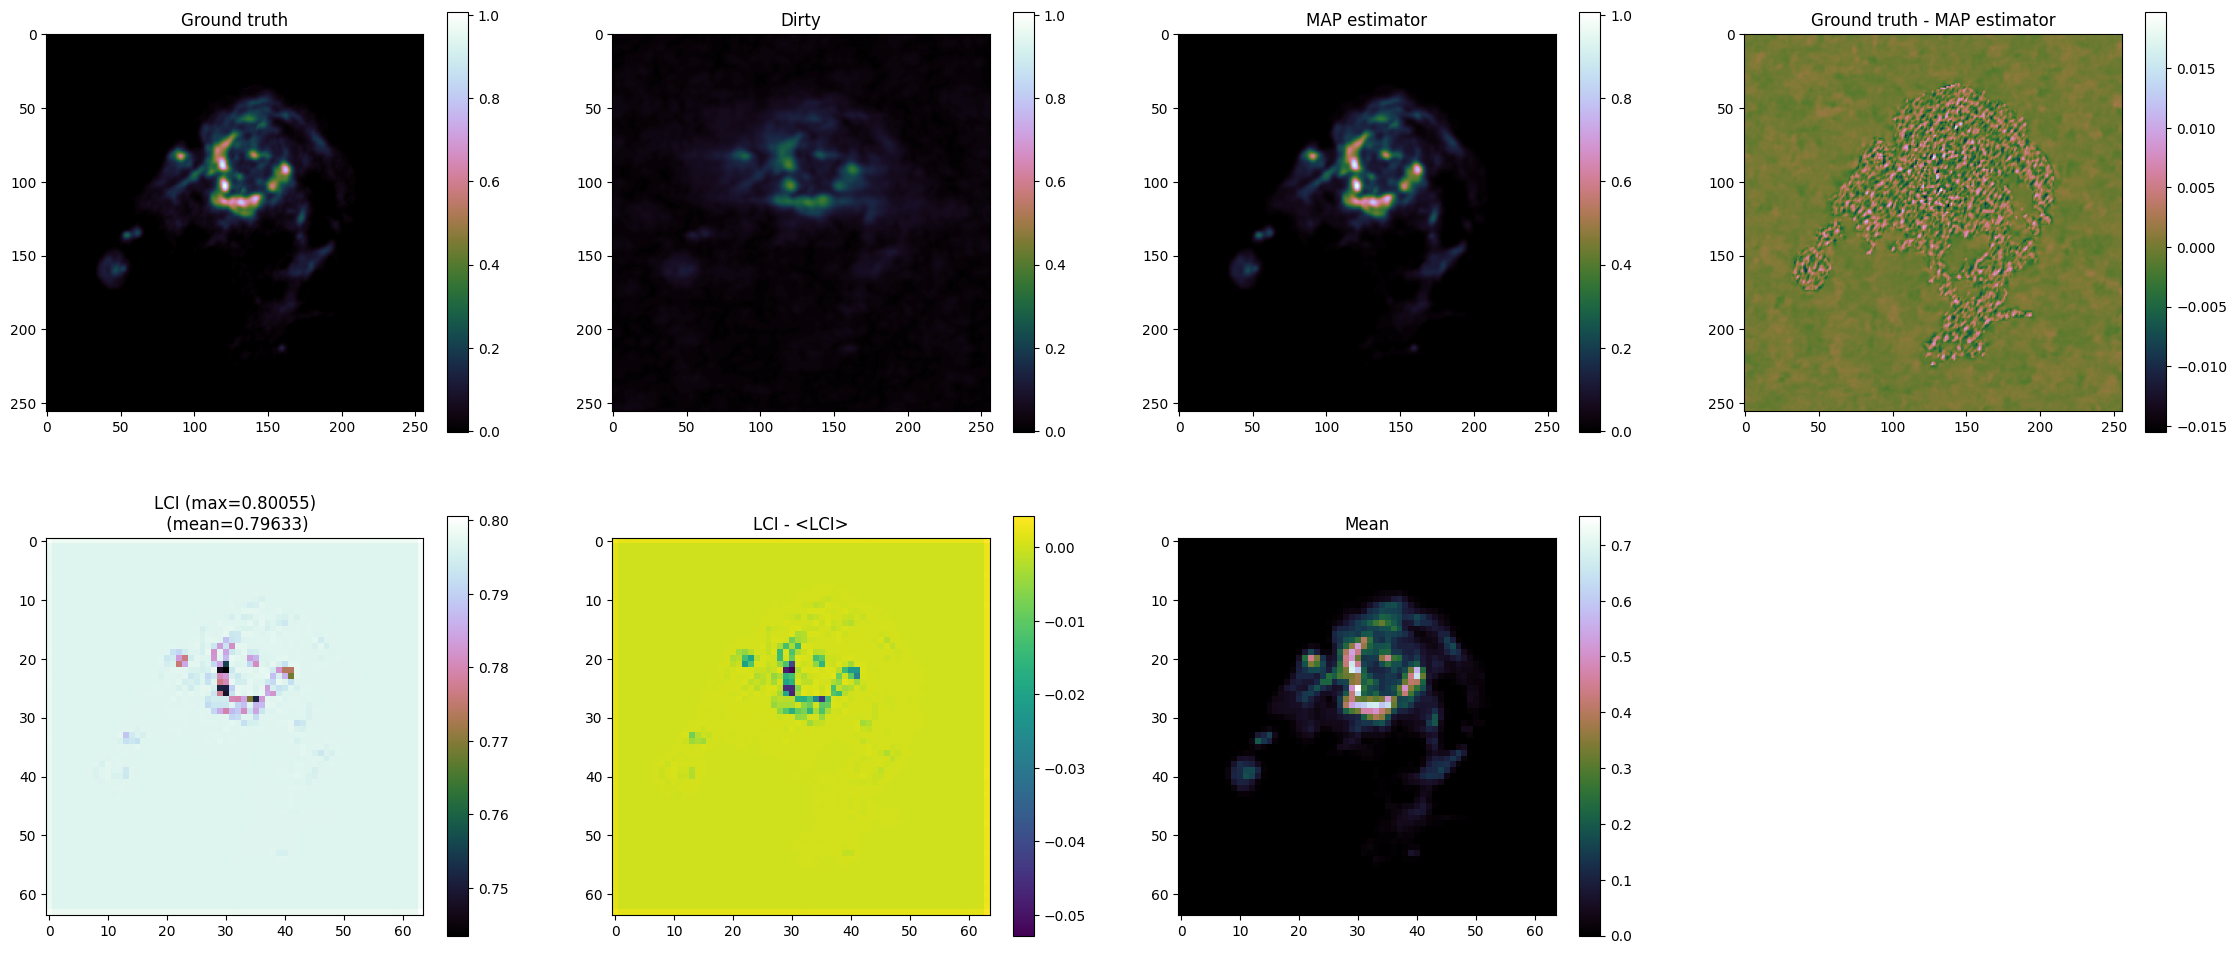

f(x_map):  2234.21826171875 
g(x_map):  30594.5234375 
tau_alpha*np.sqrt(N):  2072.011448732029 
N:  65536
tau_alpha:  8.093794721609488
gamma_alpha:  100436.75363623202


In [25]:

for it_1 in range(len(reg_params)):

    # Prior parameters
    lmbd = reg_params[it_1]

    # Compute stepsize
    alpha = 0.98 / (g.beta + mu * lmbd * L_CRR)

    # initialization
    x_hat = torch.clone(x_init)
    z = torch.clone(x_init)
    t = 1

    for it_2 in range(options['iter']):
        x_hat_old = torch.clone(x_hat)
        # grad = g.grad(z.squeeze()) +  lmbd * model(mu * z)
        x_hat = z - alpha *(
            g.grad(z) + lmbd * model(mu * z)
        )
        # Positivity constraint
        x_hat = f.prox(x_hat)
        # Positivity constraint
        # x = torch.clamp(x, 0, None)
        
        t_old = t 
        t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
        z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

        # relative change of norm for terminating
        res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

        if res < options['tol']:
            print("[GD] converged in %d iterations"%(it_2))
            break

        if it_2 % options['update_iter'] == 0:
            print(
                "[GD] %d out of %d iterations, tol = %f" %(            
                    it_2,
                    options['iter'],
                    res,
                )
            )


    # %%
    np_x_init = to_numpy(x_init)
    np_x = np.copy(x)
    np_x_hat = to_numpy(x_hat)

    images = [np_x, np_x_init, np_x_hat, np_x - np.abs(np_x_hat)]


    # %%
    labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]
    fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
    for i in range(4):
        im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
        divider = make_axes_locatable(axs[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
        if i == 0:
            stats_str = '\nRegCost {:.3f}'.format(model.cost(to_tensor(mu * images[i], device=device))[0].item())
        if i > 0:   
            stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
                psnr(np_x, images[i], data_range=np_x.max()-np_x.min()),
                luq.utils.eval_snr(x, images[i]),
                ssim(np_x, images[i], data_range=np_x.max()-np_x.min()),
                model.cost(to_tensor(mu * images[i], device=device))[0].item(),
                )
        labels[i] += stats_str
        axs[i].set_title(labels[i], fontsize=16)
        axs[i].axis('off')
    # plt.savefig('{:s}{:s}_lmbd_{:.1e}_optim_MAP.pdf'.format(savefig_dir, img_name, lmbd))
    # plt.close()
    plt.show()

    ### MAP-based UQ

    #function handles to used for ULA
    def _fun(_x, model, mu, lmbd):
        return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

    def _grad_fun(_x, g, model, mu, lmbd):
        return  torch.real(g.grad(_x) + lmbd * model(mu * _x))
    
    def _prior_fun(_x, model, mu, lmbd):
        return (lmbd / mu) * model.cost(mu * _x)

    # Evaluation of the potentials
    fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
    prior_fun = partial(_prior_fun, model=model, mu=mu, lmbd=lmbd)
    # Evaluation of the gradient
    grad_f = partial(_grad_fun, g=g, model=model, mu=mu, lmbd=lmbd)
    # Evaluation of the potential in numpy
    fun_np = lambda _x : fun(luq.utils.to_tensor(_x, dtype=myType)).item()


    # Compute HPD region bound
    N = np_x_hat.size
    tau_alpha = np.sqrt(16*np.log(3/alpha_prob))
    gamma_alpha = fun(x_hat).item() + tau_alpha*np.sqrt(N) + N

    # Compute the LCI
    LCI_iters = 200
    LCI_tol = 1e-4
    LCI_bottom = -10
    LCI_top = 10

    error_p_arr = []
    error_m_arr = []
    mean_img = []
    computing_time = []

    x_init_np = luq.utils.to_numpy(x_init)

    # Define prefix
    save_MAP_prefix = 'CRR_UQ_MAP_lmbd_{:.1e}'.format(lmbd)


    for superpix_size in superpix_MAP_sizes:

        pr_time_1 = time.process_time()
        wall_time_1 = time.time()

        error_p, error_m, mean = luq.map_uncertainty.create_local_credible_interval(
            x_sol=np_x_hat,
            region_size=superpix_size,
            function=fun_np,
            bound=gamma_alpha,
            iters=LCI_iters,
            tol=LCI_tol,
            bottom=LCI_bottom,
            top=LCI_top,
        )
        error_length = error_p - error_m

        pr_time_2 = time.process_time()
        wall_time_2 = time.time()

        error_p_arr.append(np.copy(error_p))
        error_m_arr.append(np.copy(error_m))
        mean_img.append(np.copy(mean))
        computing_time.append((
            pr_time_2 - pr_time_1, 
            wall_time_2 - wall_time_1
        ))

        vmin = np.min((x, x_init_np, np_x_hat))
        vmax = np.max((x, x_init_np, np_x_hat))
        # err_vmax= 0.6
        cmap='cubehelix'

        plt.figure(figsize=(28,12))
        plt.subplot(241)
        plt.imshow(x, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
        plt.title('Ground truth')
        plt.subplot(242)
        plt.imshow(x_init_np, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
        plt.title('Dirty')
        plt.subplot(243)
        plt.imshow(np_x_hat, cmap=cmap, vmin=vmin, vmax=vmax);plt.colorbar()
        plt.title('MAP estimator')
        plt.subplot(244)
        plt.imshow(x - np_x_hat, cmap=cmap);plt.colorbar()
        plt.title('Ground truth - MAP estimator')
        plt.subplot(245)
        plt.imshow(error_length, cmap=cmap);plt.colorbar()
        plt.title('LCI (max={:.5f})\n (mean={:.5f})'.format(
            np.max(error_length), np.mean(error_length))
        )
        plt.subplot(246)
        plt.imshow(error_length - np.mean(error_length), cmap='viridis');plt.colorbar()
        plt.title('LCI - <LCI>')
        plt.subplot(247)
        plt.imshow(mean, cmap=cmap);plt.colorbar();plt.title('Mean')
        # plt.savefig(
        #     savefig_dir+save_MAP_prefix+'_UQ-MAP_pixel_size_{:d}.pdf'.format(superpix_size)
        # )
        # plt.close()
        plt.show()


    print(
        'f(x_map): ', g.fun(x_hat).item(),
        '\ng(x_map): ', prior_fun(x_hat).item(),
        '\ntau_alpha*np.sqrt(N): ', tau_alpha*np.sqrt(N),
        '\nN: ', N,
    )
    print('tau_alpha: ', tau_alpha)
    print('gamma_alpha: ', gamma_alpha.item())

In [40]:
# Compute ground truth block 
gt_block_imgs = []
for superpix_size in superpix_MAP_sizes:

    block_image = ski.measure.block_reduce(
        np.copy(img), block_size=(superpix_size, superpix_size), func=np.mean
    )
    gt_block_imgs.append(block_image)



In [6]:

# error_length = error_p - error_m
# error_p_arr.append(np.copy(error_p))
# error_m_arr.append(np.copy(error_m))

len(error_p_arr)


4

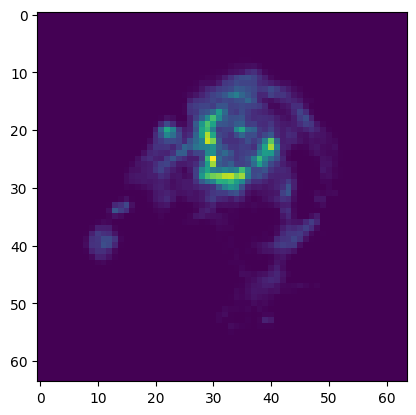

In [41]:
plt.figure()
plt.imshow(gt_block_imgs[3])



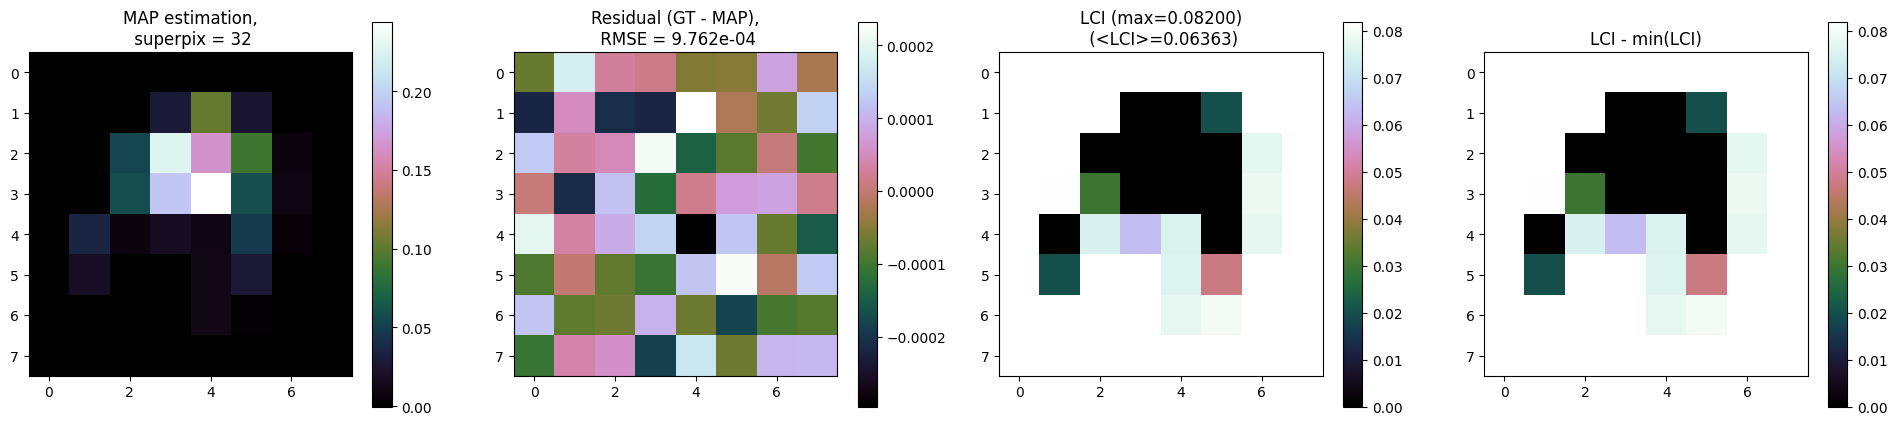

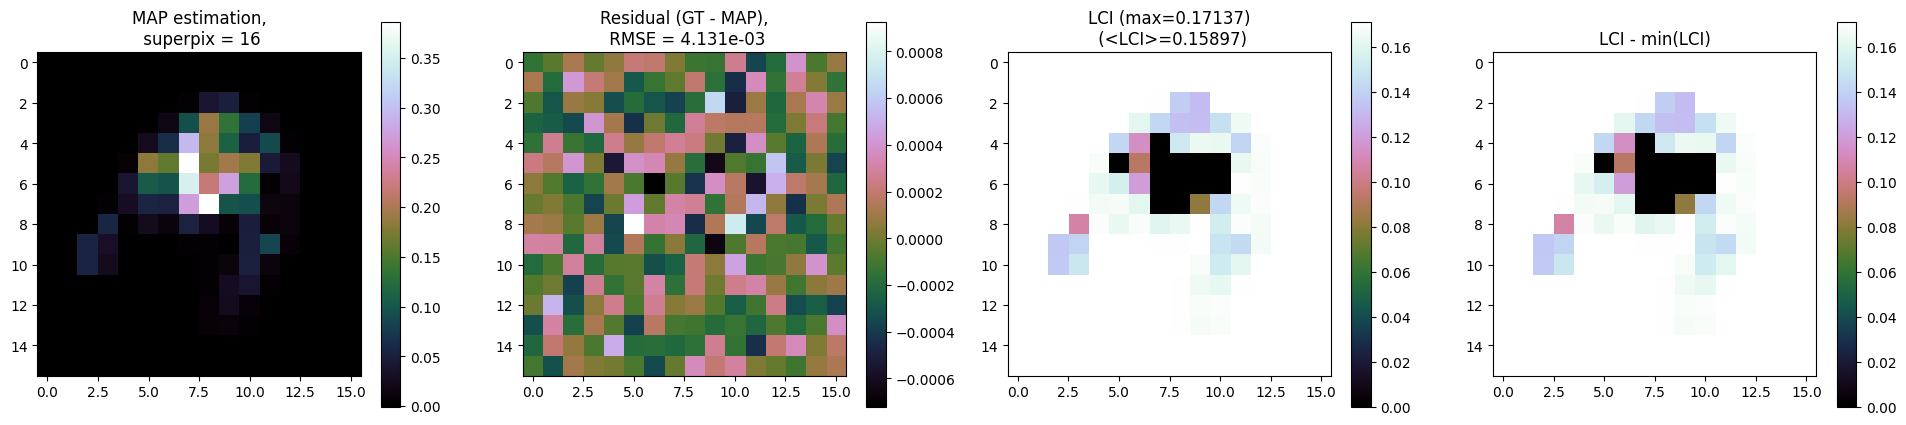

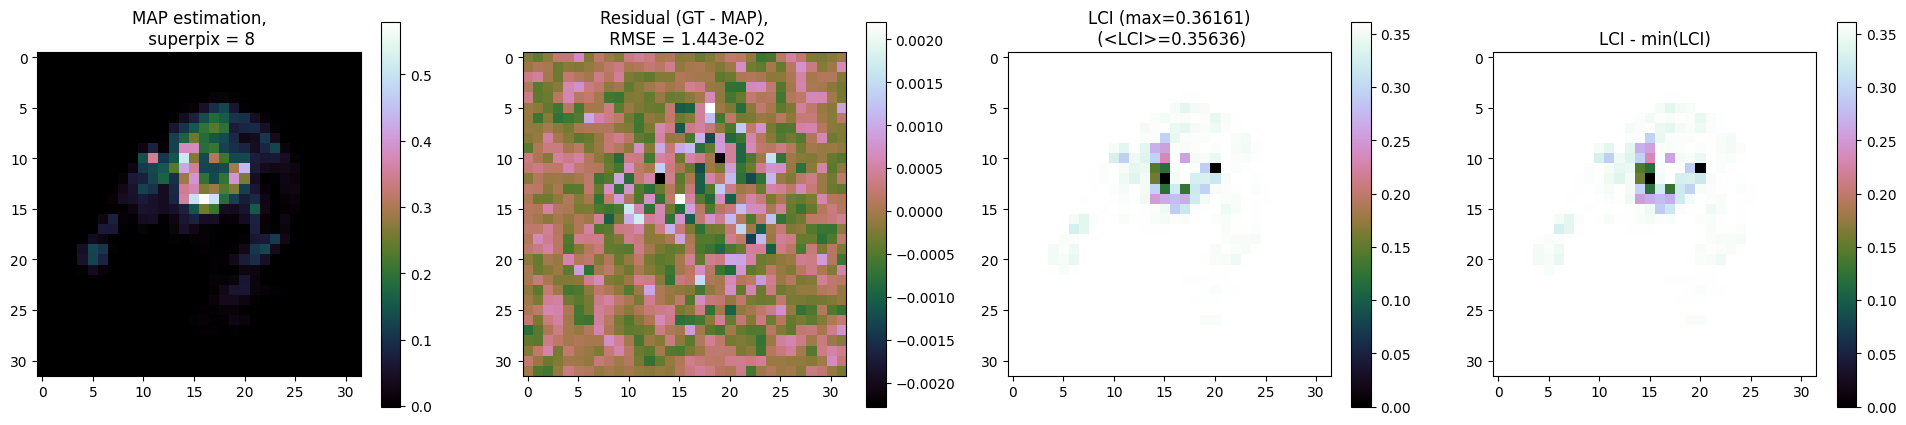

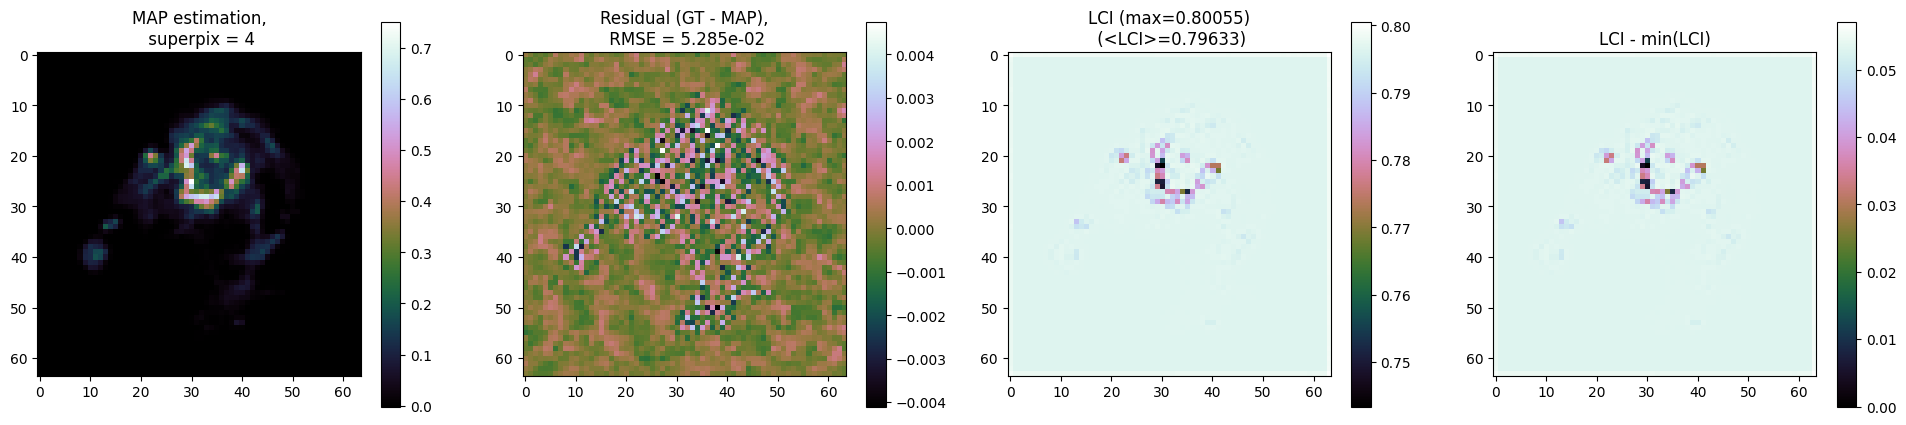

In [54]:
for it in range(len(error_p_arr)):

    error_length = error_p_arr[it] - error_m_arr[it]
    superpix_size = superpix_MAP_sizes[it]
    mean = mean_img[it]
    gt_mean = gt_block_imgs[it]

    # cmap='magma'
    cmap = 'cubehelix'

    plt.figure(figsize=(24,5))
    plt.subplot(141)
    plt.imshow(mean, cmap=cmap);plt.colorbar()
    plt.title('MAP estimation,\n superpix = {:d}'.format(superpix_size))
    plt.subplot(142)
    plt.imshow(gt_mean - mean, cmap=cmap);plt.colorbar()
    plt.title('Residual (GT - MAP),\n RMSE = {:.3e}'.format(np.sqrt(np.sum((gt_mean - mean)**2))))
    plt.subplot(143)
    plt.imshow(error_length, cmap=cmap);plt.colorbar()
    plt.title('LCI (max={:.5f})\n (<LCI>={:.5f})'.format(
        np.max(error_length), np.mean(error_length))
    )
    plt.subplot(144)
    plt.imshow(error_length - np.min(error_length), cmap=cmap);plt.colorbar()
    plt.title('LCI - min(LCI)')
    plt.savefig(
        savefig_dir+save_MAP_prefix+'_UQ-MAP_pixel_size_{:d}_nice_pic.pdf'.format(superpix_size)
    )
    # plt.close()
    plt.show()



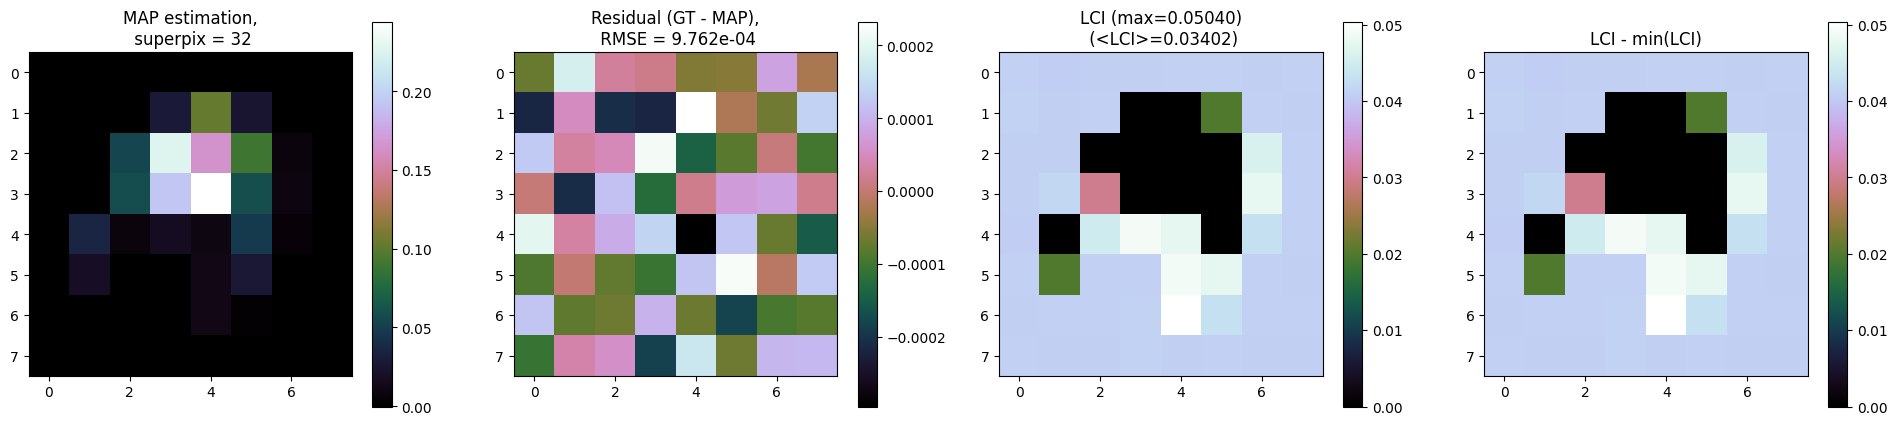

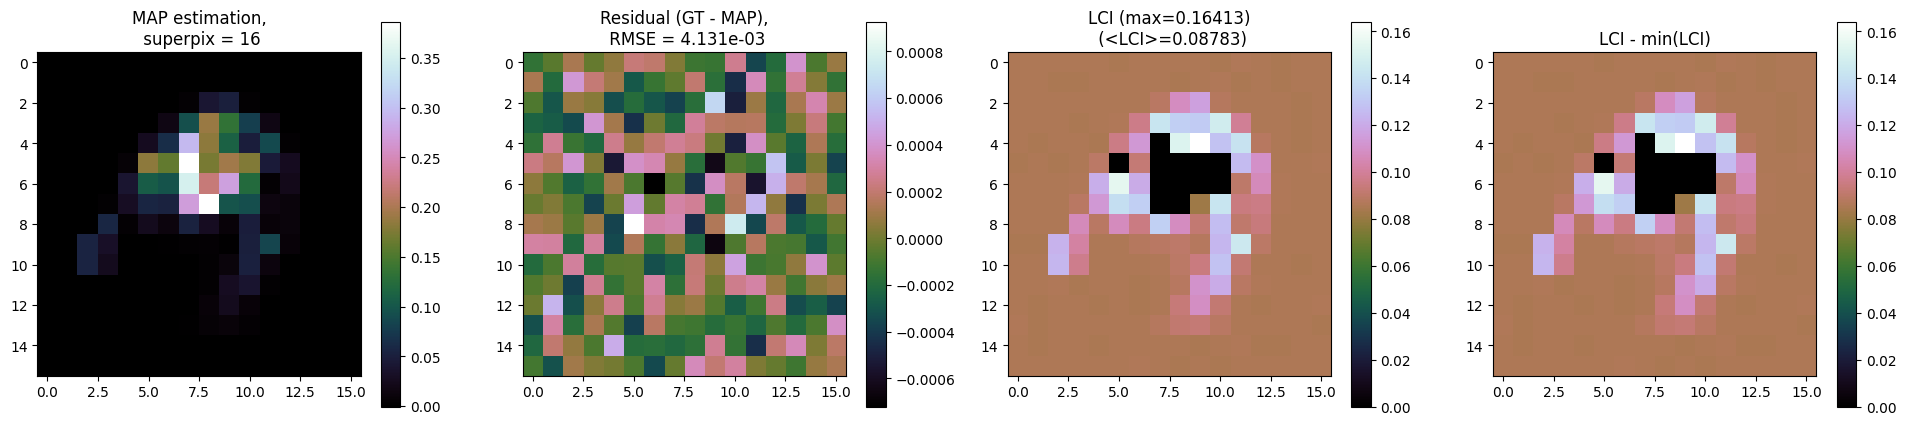

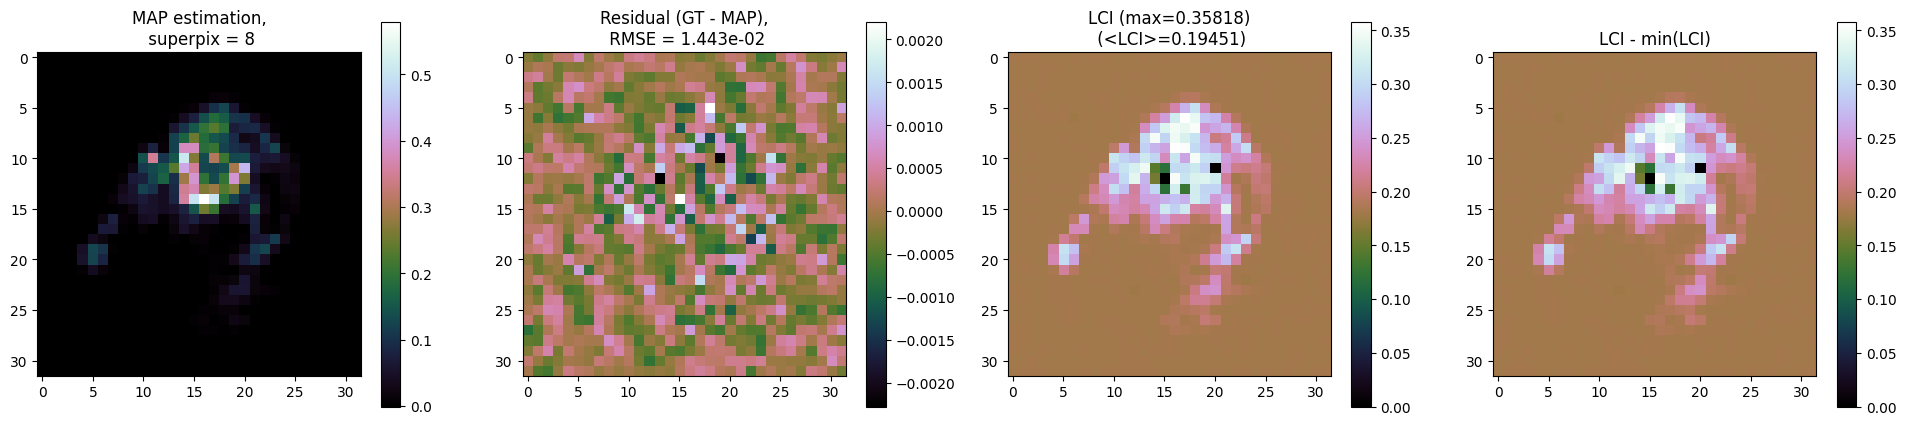

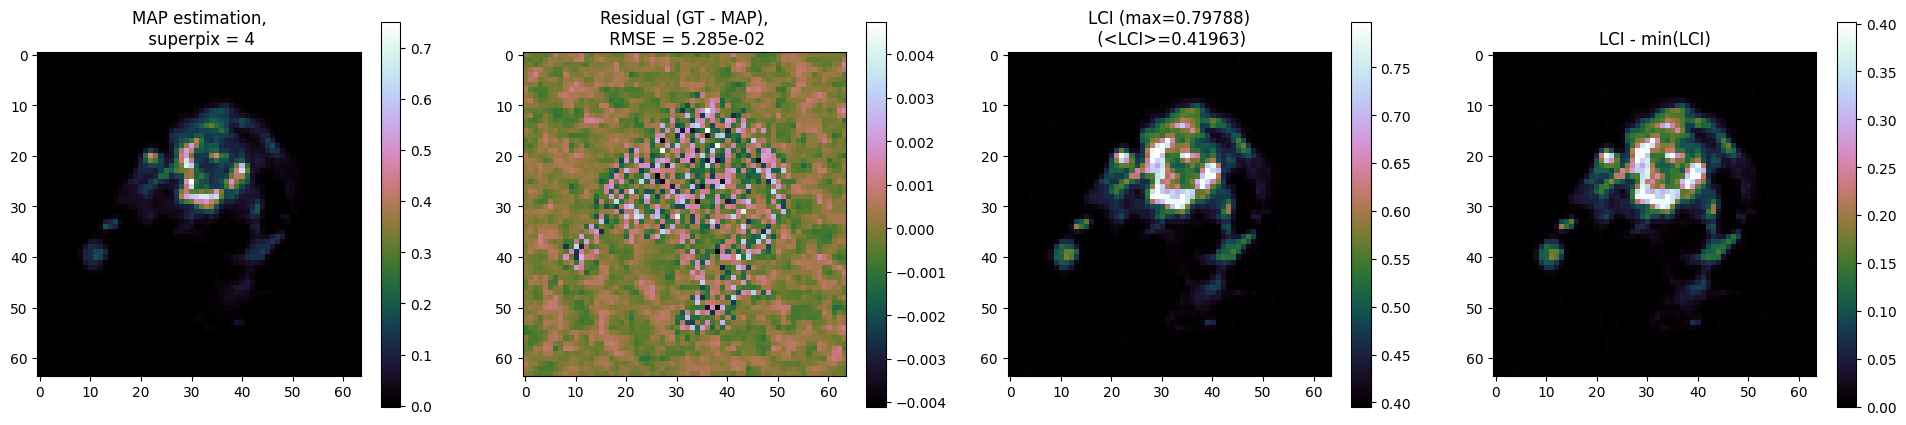

In [55]:
for it in range(len(error_p_arr)):

    error_p = np.copy(error_p_arr[it])
    error_m =  np.copy(error_m_arr[it])

    def clip_vals(mat):
        mat[mat<0] = 0
        mat[mat>=1.] = 1.
        return mat

    error_length = clip_vals(error_p) - clip_vals(error_m)
    superpix_size = superpix_MAP_sizes[it]
    mean = mean_img[it]
    gt_mean = gt_block_imgs[it]

    # cmap='magma'
    cmap = 'cubehelix'

    plt.figure(figsize=(24,5))
    plt.subplot(141)
    plt.imshow(mean, cmap=cmap);plt.colorbar()
    plt.title('MAP estimation,\n superpix = {:d}'.format(superpix_size))
    plt.subplot(142)
    plt.imshow(gt_mean - mean, cmap=cmap);plt.colorbar()
    plt.title('Residual (GT - MAP),\n RMSE = {:.3e}'.format(np.sqrt(np.sum((gt_mean - mean)**2))))
    plt.subplot(143)
    plt.imshow(error_length, cmap=cmap);plt.colorbar()
    plt.title('LCI (max={:.5f})\n (<LCI>={:.5f})'.format(
        np.max(error_length), np.mean(error_length))
    )
    plt.subplot(144)
    plt.imshow(error_length - np.min(error_length), cmap=cmap);plt.colorbar()
    plt.title('LCI - min(LCI)')
    plt.savefig(
        savefig_dir+save_MAP_prefix+'_UQ-MAP_pixel_size_{:d}_nice_pic_clipped.pdf'.format(superpix_size)
    )
    # plt.close()
    plt.show()